In [2]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
from selenium.webdriver.chrome.options import Options
import numpy as np

# Housing Dataset

In [3]:
house_driver = webdriver.Chrome()
house_driver.get('https://texas.hometownlocator.com/zip-codes/zipcodes,city,houston.cfm')
content = house_driver.page_source
soup = BeautifulSoup(content)

In [4]:
zip_codes = list()
standard_zip = soup.findAll('td')[2]
links = standard_zip.findAll('a')

for i in range(0,len(links)-1):
    zip_codes.append(links[i].text)

In [5]:
urls = list()

for a_tag in links:
    url = a_tag['href']
    if not url.startswith('http'):
        url = "https://texas.hometownlocator.com/zip-codes/"+url
    urls.append(url)

In [6]:
urls[0:3]

['https://texas.hometownlocator.com/zip-codes/data,zipcode,77002.cfm',
 'https://texas.hometownlocator.com/zip-codes/data,zipcode,77003.cfm',
 'https://texas.hometownlocator.com/zip-codes/data,zipcode,77004.cfm']

# Crawlling

In [24]:
driverOtp = webdriver.ChromeOptions()
driverOtp.add_argument("--headless")

data_driver = webdriver.Chrome(options=driverOtp)
data_driver.get('https://texas.hometownlocator.com/zip-codes/data,zipcode,77002.cfm')
content = data_driver.page_source
soup = BeautifulSoup(content)

In [30]:
tables = soup.findAll('div', {'class':'halfcontentpadded'})
variables = list()

for i in tables[3].findAll('span',{'class':'indent'}):
    variables.append(i.text)
for i in tables[4].findAll('span',{'class':'indent'}):
    variables.append(i.text)

In [31]:
variables
y = {a : [] for a in variables}
y

{'Total Population': [],
 'Population in Households': [],
 'Population in Familes': [],
 'Population in Group Qrtrs': [],
 'Population Density': [],
 'Diversity Index1': [],
 'Median Household Income': [],
 'Average Household Income': [],
 'Per Capita Income': [],
 'Wealth Index3': [],
 'Total Housing Units': [],
 'Owner Occupied HU': [],
 'Renter Occupied HU': [],
 'Vacant Housing Units': [],
 'Median Home Value': [],
 'Housing Affordability Index2': [],
 'Total Households': [],
 'Average Household Size': [],
 'Family Households': [],
 'Average Family Size': []}

In [37]:
vals = tables[3].findAll('td',{'align':'right'}) + tables[4].findAll('td',{'align':'right'})

for key,i in zip(y,range(len(y))):
    y[key].append(vals[i].text)


In [38]:
vals

[<td align="right">22,953</td>,
 <td align="right">9,717</td>,
 <td align="right">3,207</td>,
 <td align="right">13,236</td>,
 <td align="right">11,072</td>,
 <td align="right">74</td>,
 <td align="right">$81,974</td>,
 <td align="right">$122,502</td>,
 <td align="right">$41,730</td>,
 <td align="right"> 86</td>,
 <td align="right">8,072 (100%)</td>,
 <td align="right">935 (11.6%)</td>,
 <td align="right">5,782 (71.6%)</td>,
 <td align="right">1,355 (16.8%)</td>,
 <td align="right">$331,653</td>,
 <td align="right">129</td>,
 <td align="right">6,717</td>,
 <td align="right">1.45</td>,
 <td align="right">1,266</td>,
 <td align="right">3</td>]

In [42]:
y

{'Total Population': ['22,953'],
 'Population in Households': ['9,717'],
 'Population in Familes': ['3,207'],
 'Population in Group Qrtrs': ['13,236'],
 'Population Density': ['11,072'],
 'Diversity Index1': ['74'],
 'Median Household Income': ['$81,974'],
 'Average Household Income': ['$122,502'],
 'Per Capita Income': ['$41,730'],
 'Wealth Index3': [' 86'],
 'Total Housing Units': ['8,072 (100%)'],
 'Owner Occupied HU': ['935 (11.6%)'],
 'Renter Occupied HU': ['5,782 (71.6%)'],
 'Vacant Housing Units': ['1,355 (16.8%)'],
 'Median Home Value': ['$331,653'],
 'Housing Affordability Index2': ['129'],
 'Total Households': ['6,717'],
 'Average Household Size': ['1.45'],
 'Family Households': ['1,266'],
 'Average Family Size': ['3']}

In [46]:
def parse_zip_page(page_url,dictionary):
    """ this function will crawl to the link provided and update the dictionary"""
    driverOtp = webdriver.ChromeOptions()
    driverOtp.add_argument("--headless")

    data_driver = webdriver.Chrome(options=driverOtp)
    data_driver.get(page_url)
    content = data_driver.page_source
    soup = BeautifulSoup(content)
    
    tables = soup.findAll('div', {'class':'halfcontentpadded'})
    vals = tables[3].findAll('td',{'align':'right'}) + tables[4].findAll('td',{'align':'right'})
    
    for key,i in zip(dictionary,range(len(dictionary))):
        dictionary[key].append(vals[i].text)
    
    data_driver.quit()
    

def create_variables():
    """ Return an empty dictionary with all the variables to be collected """
    
    tables = soup.findAll('div', {'class':'halfcontentpadded'})

    variables = list()

    for i in tables[3].findAll('span',{'class':'indent'}):
        variables.append(i.text)
    for i in tables[4].findAll('span',{'class':'indent'}):
        variables.append(i.text)
    y = {a : [] for a in variables}
    
    return y


def update(page_url,dictionary):
    """"This function return dictionary,
    you need to provide a dictionary with the correct keys"""
    parse_zip_page(page_url,dictionary)
    return dictionary

In [47]:
dictionary = create_variables()

In [1]:
temp = None
count = 0
for i in urls:
    count = count + 1
    temp = update(i,dictionary)

In [180]:
texas_Gazetteer = pd.DataFrame.from_dict(temp, orient='columns')
texas_Gazetteer.index = zip_codes

In [181]:
dollar_signs = ['Median Household Income','Average Household Income','Per Capita Income','Median Home Value']

In [182]:
splits_columns = ['Total Housing Units','Owner Occupied HU','Renter Occupied HU','Vacant Housing Units']

In [183]:
for i in variables:
    texas_Gazetteer[i] = texas_Gazetteer[i].str.replace(',','')
    texas_Gazetteer[i] = texas_Gazetteer[i].str.replace('$', '')
    new = texas_Gazetteer[i].str.split(n = 1, expand = True)
    texas_Gazetteer[i] = new[0]

In [184]:
texas_Gazetteer.head()
#texas_Gazetteer.to_csv('texas_Gazetteer_object.csv', index=True)

In [185]:
texas_Gazetteer['Average Household Size'] = texas_Gazetteer['Average Household Size'].astype(float)

In [186]:
floats = texas_Gazetteer.select_dtypes(object).apply(pd.to_numeric,downcast = 'integer')
texas_Gazetteer[floats.columns] = floats.values
texas_Gazetteer.dtypes

Total Population                  int64
Population in Households          int64
Population in Familes             int64
Population in Group Qrtrs         int64
Population Density                int64
Diversity Index1                  int64
Median Household Income           int64
Average Household Income          int64
Per Capita Income                 int64
Wealth Index3                     int64
Total Housing Units               int64
Owner Occupied HU                 int64
Renter Occupied HU                int64
Vacant Housing Units              int64
Median Home Value                 int64
Housing Affordability Index2      int64
Total Households                  int64
Average Household Size          float64
Family Households                 int64
Average Family Size               int64
dtype: object

In [187]:
texas_Gazetteer.head()

,Total Population,Population in Households,Population in Familes,Population in Group Qrtrs,Population Density,Diversity Index1,Median Household Income,Average Household Income,Per Capita Income,Wealth Index3,Total Housing Units,Owner Occupied HU,Renter Occupied HU,Vacant Housing Units,Median Home Value,Housing Affordability Index2,Total Households,Average Household Size,Family Households,Average Family Size
77002,22953,9717,3207,13236,11072,74,81974,122502,41730,86,8072,935,5782,1355,331653,129,6717,1.45,1266,3
77003,13794,12605,8571,1189,4899,85,55802,80953,31571,65,6162,2310,3038,814,312172,89,5348,2.36,2511,3
77004,37705,29691,17863,8014,6893,69,47584,79758,32814,65,18991,4692,10191,4108,316998,67,14883,1.99,6053,3
77005,30451,27808,22522,2643,7779,49,163237,226484,86773,305,12195,7385,4251,559,963404,82,11636,2.39,7314,3
77006,24403,23757,9644,646,10735,63,73223,114010,68971,97,16535,4779,9964,1792,460751,75,14743,1.61,3821,3


In [179]:
#texas_Gazetteer.to_csv('texas_Gazetteer_numeric.csv', index=True)

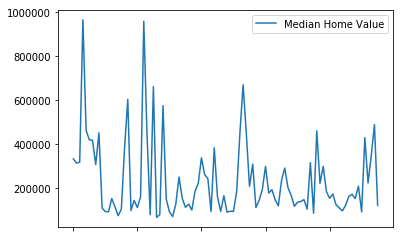

In [192]:
texas_Gazetteer.plot(use_index=True, y='Median Home Value')

In [196]:
texas_Gazetteer.describe()

,Total Population,Population in Households,Population in Familes,Population in Group Qrtrs,Population Density,Diversity Index1,Median Household Income,Average Household Income,Per Capita Income,Wealth Index3,Total Housing Units,Owner Occupied HU,Renter Occupied HU,Vacant Housing Units,Median Home Value,Housing Affordability Index2,Total Households,Average Household Size,Family Households,Average Family Size
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.00000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,34066.250000,33629.416667,27260.010417,436.833333,4875.333333,76.583333,58062.635417,81435.343750,32120.427083,82.000000,13403.31250,5759.114583,6364.427083,1279.770833,234564.625000,136.500000,12123.541667,2.817500,7827.000000,3.510417
std,17074.223046,17215.157264,15198.939952,1584.465008,2593.378096,10.697434,27549.832870,40960.572703,22708.804814,60.903029,6657.81007,3567.030293,4082.780858,846.240410,177305.914516,51.306714,6130.555137,0.609447,4195.568286,0.542796
min,474.000000,474.000000,164.000000,0.000000,634.000000,37.000000,25024.000000,35553.000000,11455.000000,25.000000,360.00000,34.000000,224.000000,36.000000,65500.000000,0.000000,324.000000,1.440000,66.000000,2.000000
25%,22836.750000,22198.750000,16297.250000,11.250000,3155.500000,70.000000,39509.500000,52707.000000,15884.750000,40.000000,9052.75000,3409.750000,3393.750000,723.250000,111284.250000,93.000000,8236.750000,2.397500,4983.000000,3.000000
50%,32130.500000,31666.500000,25952.000000,109.500000,4510.000000,79.500000,50490.500000,67006.000000,22082.000000,54.500000,12189.50000,5114.500000,5487.500000,1131.000000,165034.000000,138.500000,11010.000000,2.925000,7373.500000,4.000000
75%,41968.250000,41450.750000,34196.250000,268.000000,6193.500000,85.000000,71162.750000,105174.500000,40210.500000,109.500000,16810.75000,7349.250000,8262.750000,1783.000000,308960.500000,170.250000,15153.750000,3.265000,9583.500000,4.000000
max,110665.000000,110645.000000,95974.000000,13236.000000,16343.000000,90.000000,165825.000000,226484.000000,124622.000000,324.000000,37884.00000,22690.000000,21704.000000,5438.000000,963404.000000,311.000000,36062.000000,3.980000,26988.000000,4.000000
